# Read a roast file

Did my first roast.  File is `data/roastomatic_202050224T181213.txt`

There's a 13 line header where the serial monitor is attaching.  I don't know whether that's consistent across runs or not.  Then, the board reset when I hit the drop, which is fine for now, but I need to debug.  So only the first 2700 or so lines are valid.  It's sampled a 4Hz.

In [107]:
# standard packages
import bisect


# third-party packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt


# Read the data
file = '../data/roastomatic_20250224T181213.txt'
names = [
    "roast_time",
    "total_time",
    "state",
    "fan_value",
    "heat_value",
    "bean_temp_f", 
    "intake_temp_f",
    "weight",
    "drop_percent"
]

df = pd.read_csv(file,names=names,skiprows=14,nrows=(2710-14))

# convert milliseconds to timedelta


# Integer representing milliseconds
for times in ["total_time", "roast_time"]:
    df[times] = pd.to_timedelta(df[times],unit='milliseconds').dt.total_seconds()
df


,roast_time,total_time,state,fan_value,heat_value,bean_temp_f,intake_temp_f,weight,drop_percent
0,0.000,0.788,heat,0,0,63.95,64.85,373639.00,0.00
1,0.000,1.085,heat,0,0,63.95,64.85,373738.00,0.00
2,0.000,1.357,heat,0,0,63.05,64.40,373745.00,0.00
3,0.000,1.655,heat,0,0,63.50,64.85,373804.00,0.00
4,0.000,1.927,heat,0,0,63.50,64.85,373705.00,0.00
...,...,...,...,...,...,...,...,...,...
2691,560.461,766.464,cook,4095,4095,369.95,297.05,85.12,5.52
2692,560.755,766.758,cook,4095,4095,369.95,296.60,86.74,3.73
2693,561.027,767.030,cook,4095,4095,370.40,297.50,83.73,7.07
2694,561.322,767.325,cook,4095,4095,370.40,297.50,81.70,9.33


## Roast Profile
First thing is to plot everything during the cook state vs roast_time


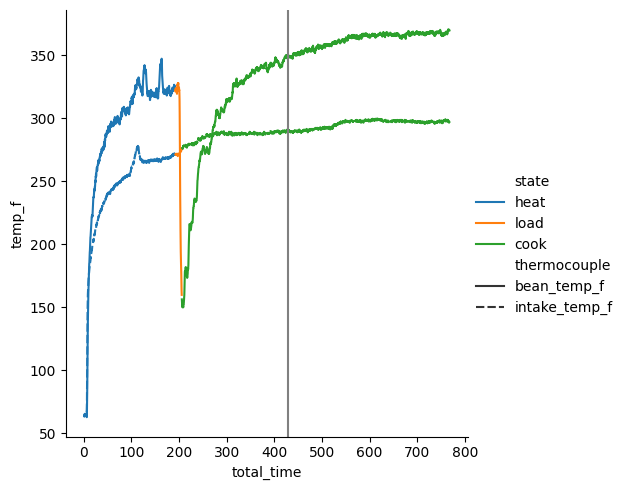

In [108]:

df_melted = df.melt(id_vars=['total_time','state'], value_vars=['bean_temp_f', 'intake_temp_f'], var_name='thermocouple', value_name='temp_f')
sns.relplot(data=df_melted, x="total_time", y="temp_f", hue="state", style="thermocouple", kind="line")
plt.axvline(x=7*60+9, color='gray')
plt.show()

## Noise Characteristics of Temperature

Text(0.5, 1.0, 'Power Spectrum (High-Frequency Noise)')

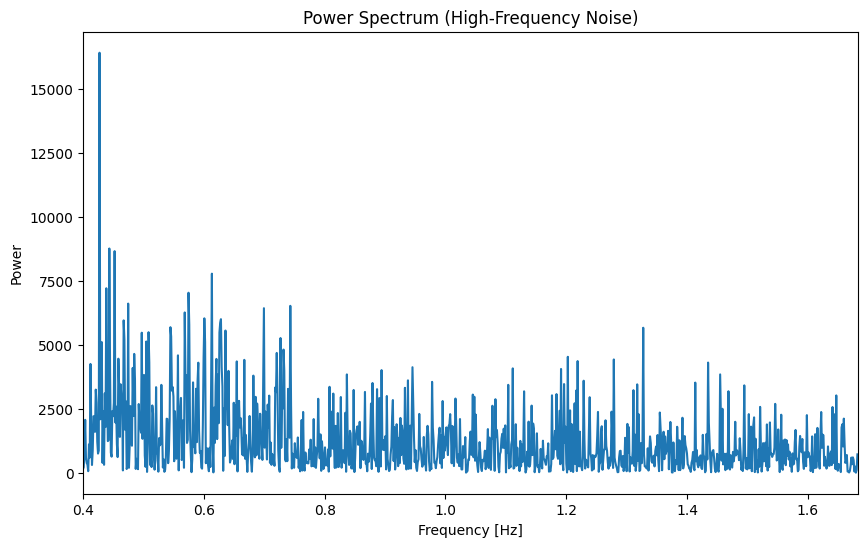

In [116]:
series = df["bean_temp_f"]
time = df["total_time"]

# Define a high-pass filter
def high_pass_filter(data, cutoff_freq, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply high-pass filter to remove low-frequency components
cutoff_freq = 0.4  # Cut-off frequency in Hz
fs = 1 / (time[1] - time[0])  # Sampling frequency
filtered_signal = high_pass_filter(series, cutoff_freq, fs)

# Calculate the FFT of the filtered series
fft_values = np.fft.fft(filtered_signal)

# Compute the power spectrum
power_spectrum = np.abs(fft_values) ** 2

# Frequency array
freq = np.fft.fftfreq(len(series), d=time[1] - time[0])

# Plot the power spectrum focusing on high frequencies
plt.figure(figsize=(10, 6))
plt.plot(freq[:len(freq)//2], power_spectrum[:len(power_spectrum)//2])  # Plot only positive frequencies
plt.xlim([cutoff_freq, fs / 2])  # Limit x-axis to high frequencies
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power Spectrum (High-Frequency Noise)')

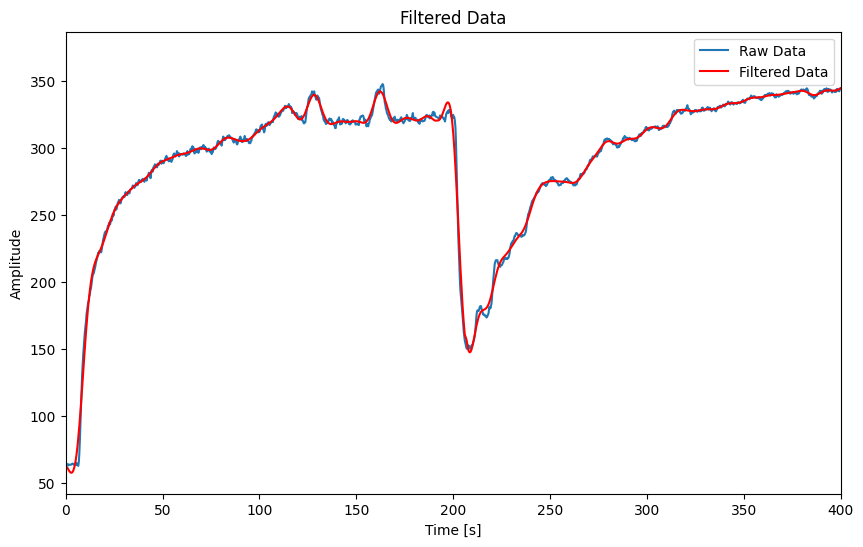

In [117]:

# Define a low-pass filter
def low_pass_filter(data, cutoff_freq, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Identify the cutoff frequency from the power spectrum plot
cutoff_freq = 0.09 # Example cutoff frequency in Hz (adjust based on your analysis)
fs = 1 / (time[1] - time[0])  # Sampling frequency

# Apply the low-pass filter
filtered_signal = low_pass_filter(series, cutoff_freq, fs)

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(time, series, label='Raw Data')
plt.plot(time, filtered_signal, label='Filtered Data', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Filtered Data')

plt.xlim((0,400))
plt.legend()
plt.show()


### Offsets
I heard the first crack a 429 seconds.  That was 21.7 degrees lower than the final roast temperature.  I don't remember exactly the weight loss but it was over 15%.  This would put us clearly in French roast territory.  If first crack happens at 405F and I stopped at 448F, that's a pretty wide gap.

In [118]:
index = bisect.bisect_left(time,7*60+9)
first_crack_bean_temp = filtered_signal[index]

max_bean_temp = max(df['bean_temp_f'])
print(f"First Crack Measured: {first_crack_bean_temp:3.1f}F")
print(f"Max: {max_bean_temp:3.1f}F")

First Crack Measured: 349.2F
Max: 370.9F


The thermocouples read high relative to ambient temperature when i was installing them.  This suggests that i need both offset and gain correction.  If $y$ is the actual temperature and $x$ is the read temperature, then I have a simple linear model.
$ y = ax + b $  where $a$ is the gain and $b$ is the offset.

I can measure this, but my best guess is that the offset is around 9 degrees at room temperature.  To calculate gain.  I've got three points.  350 measured at 405 truth.  And let's call it 75F and 65F for room temperature measured and truth.  Finally the max temperature was likely 448F truth and 370.9 measured 

In [119]:
gain = (405-75) / (349.2-65)
offset = 405 - gain * 349.2

corrected_max_bean_temp = gain * max_bean_temp + offset

print(f"Offset: {offset:3.1f}F")
print(f"Gain: {gain:3.1f}")
print(f"Raw Max: {max_bean_temp:3.1f}F")
print(f"Corrected Max: {corrected_max_bean_temp:3.1f}F")



Offset: -0.5F
Gain: 1.2
Raw Max: 370.9F
Corrected Max: 430.1F


Since we have 3 reference points, we can also fit a quadratic.

In [121]:
T_real = np.array([65, 405, 448])  # Known real temperatures (°C)
T_raw = np.array([75, 349.2, 370.9])    # MAX6675 readings (°C)

coeffs = np.polyfit(T_raw, T_real, 2)  # Returns [a, b, c]

print(f"a = {coeffs[0]:0.4f}, b = {coeffs[1]:0.4f}, c = {coeffs[2]:2.4f}")


a = 0.0025, b = 0.1768, c = 37.6406


Applying the low-pass filter and the quadratic to all the data.  We remove the edges of the data where the filter breaks down. 

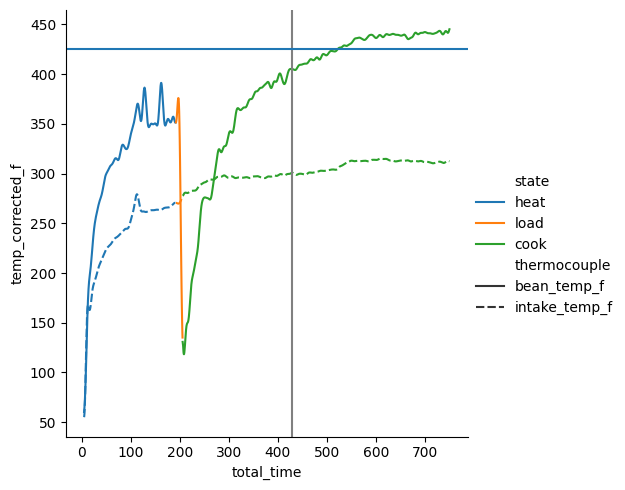

In [136]:
df_melted["temp_corrected_f"] = np.polyval(coeffs, low_pass_filter(df_melted["temp_f"], cutoff_freq, fs))
df_subset = df_melted[(df_melted["total_time"]>5) & (df_melted["total_time"]<750)]
city_roast_temp = 425
sns.relplot(data=df_subset, x="total_time", y="temp_corrected_f", hue="state", style="thermocouple", kind="line")
plt.axvline(x=7*60+9, color='gray')
plt.axhline(y=city_roast_temp)
plt.show()

### First Crack estimates

You can also estimate the first crack by graphing the first derivative of bean temperature